# Richter's Predictor: Modeling Earthquake Damage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef, precision_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from copy import copy, deepcopy
from tqdm import tnrange, tqdm_notebook, tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.simplefilter(action='ignore')
%matplotlib inline

## Data Loading

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
labels = pd.read_csv('train_labels.csv')

In [3]:
train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [5]:
labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


Merging the labels/target with the training dataset.

In [6]:
df = pd.merge(train,labels,on='building_id')

In [7]:
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3


In [8]:
df.isnull().sum().any()

False

In [9]:
df.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,5.256755e+05,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,...,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119,2.238272
std,3.045450e+05,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,...,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364,0.611814
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.611900e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,5.257570e+05,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,7.897620e+05,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [10]:
df.count_families.value_counts()

1    226115
0     20862
2     11294
3      1802
4       389
5       104
6        22
7         7
9         4
8         2
Name: count_families, dtype: int64

In [11]:
df.count_floors_pre_eq.value_counts()

2    156623
3     55617
1     40441
4      5424
5      2246
6       209
7        39
9         1
8         1
Name: count_floors_pre_eq, dtype: int64

In [12]:
df.age.value_counts()

10     38896
15     36010
5      33697
20     32182
0      26041
25     24366
30     18028
35     10710
40     10559
50      7257
45      4711
60      3612
80      3055
55      2033
70      1975
995     1390
100     1364
65      1123
90      1085
85       847
75       512
95       414
120      180
150      142
200      106
110      100
105       89
125       37
115       21
140        9
130        9
180        7
160        6
170        6
175        5
135        5
145        3
190        3
195        2
165        2
155        1
185        1
Name: age, dtype: int64

In [13]:
df.area_percentage.value_counts()

6      42013
7      36752
5      32724
8      28445
9      22199
       ...  
82         1
80         1
78         1
75         1
100        1
Name: area_percentage, Length: 84, dtype: int64

In [14]:
cat_var = ['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status']
num_var = ['count_floors_pre_eq','age','area_percentage','height_percentage','count_families']
int_columns = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']

# Exploratory Data Analysis

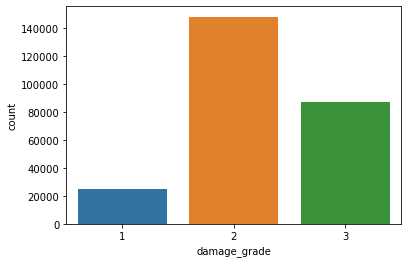

In [15]:
sns.countplot(x='damage_grade', data=df);

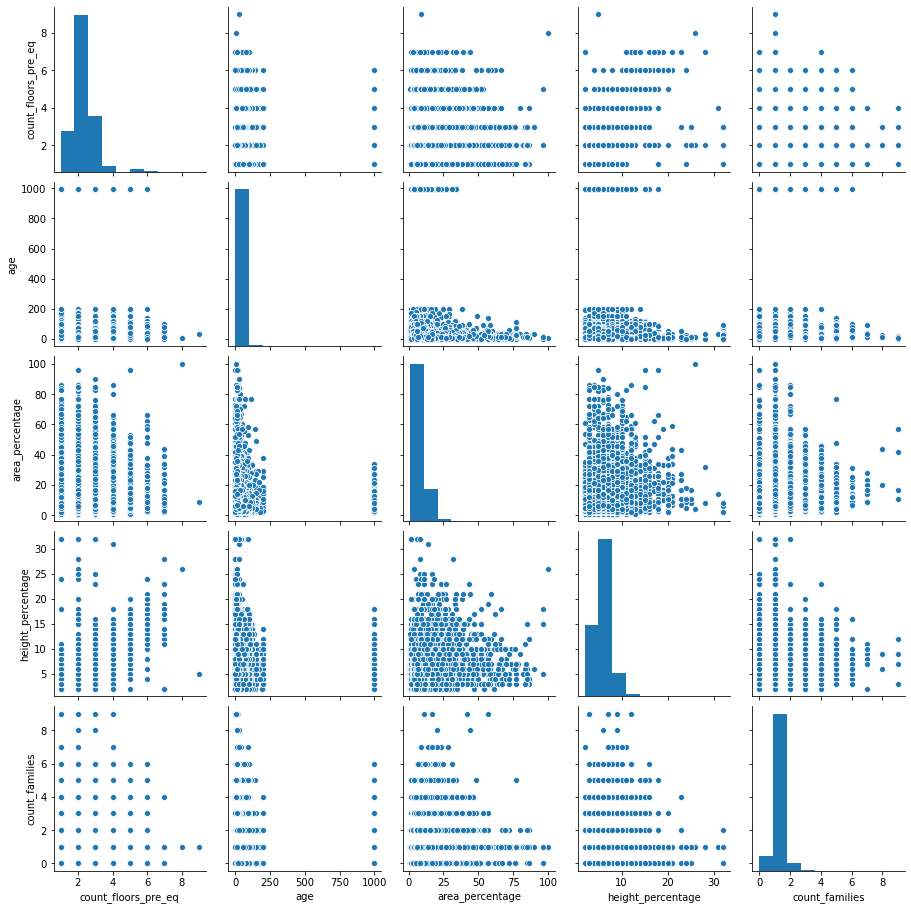

In [16]:
sns.pairplot(df[num_var])

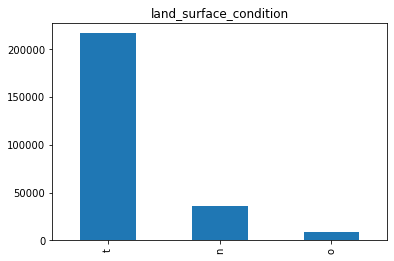

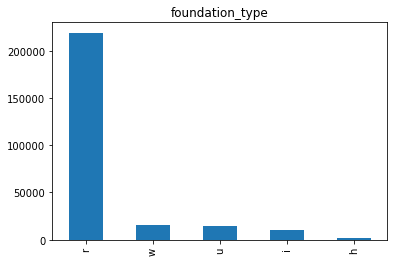

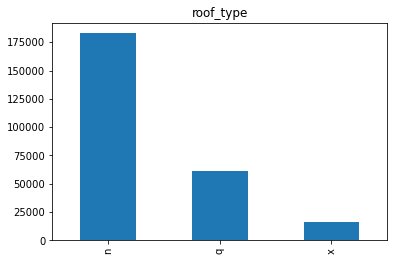

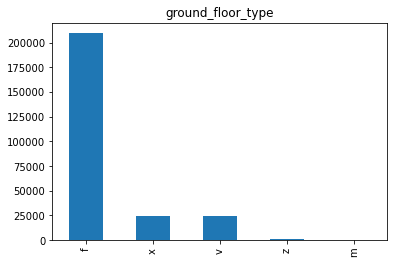

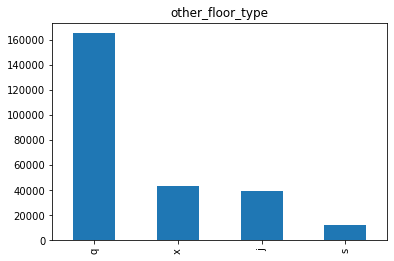

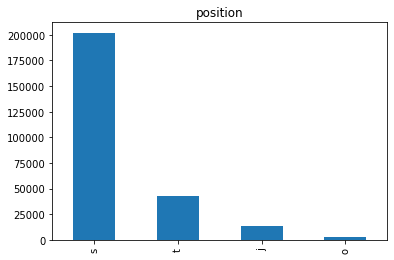

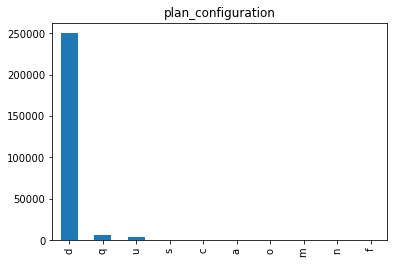

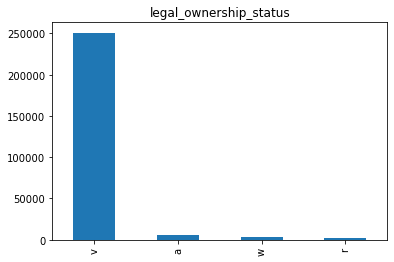

In [17]:
df.shape
df.isnull().sum()
df.isnull
labels.damage_grade.value_counts()
for i in df.columns[df.dtypes==object]:
    df[i].value_counts().plot(kind='bar')
    plt.title(i)
    plt.show()

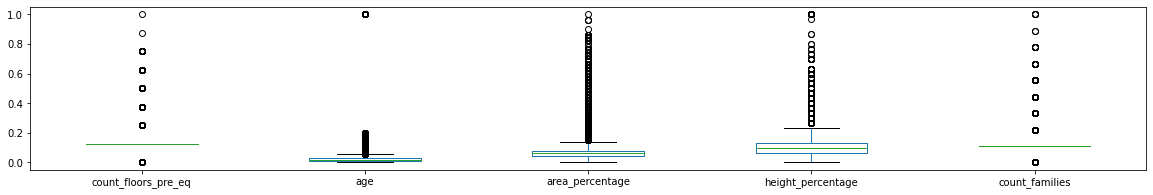

In [18]:
scaler = MinMaxScaler()
Temp = copy(df)
#ls= Temp.columns[Temp.dtypes!=object].tolist()
Temp[num_var] = scaler.fit_transform(Temp[num_var])
Temp[num_var].plot(kind='box',figsize=(20,3))

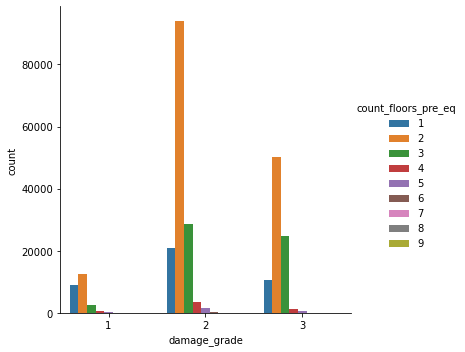

In [19]:
sns.catplot(x='damage_grade', hue='count_floors_pre_eq', kind='count', data=df);

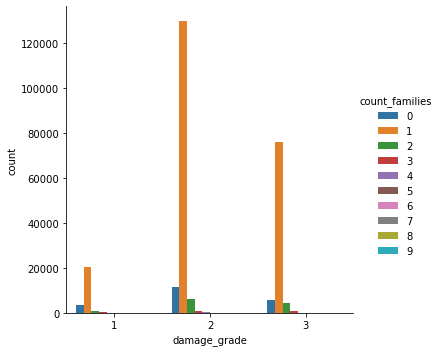

In [20]:
sns.catplot(x='damage_grade', hue='count_families', kind='count', data=df);

In [21]:
from scipy.special import boxcox1p
from scipy.stats import kurtosis, skew, boxcox_normmax

#'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']
# satisfaction level
print('kurtosis for satisfaction level feature is: {}'.format(kurtosis(df['geo_level_1_id'])))
print('skewness for satisfaction level feature is: {}'.format(skew(df['geo_level_1_id'])))
print('')
# last evaluation
print('kurtosis for last evaluation feature is: {}'.format(kurtosis(df['geo_level_2_id'])))
print('skewness for last evaluation feature level is: {}'.format(skew(df['geo_level_2_id'])))
print('')
# number of projects
print('kurtosis for number of projects feature is: {}'.format(kurtosis(df['geo_level_3_id'])))
print('skewness for number of projects feature is: {}'.format(skew(df['geo_level_3_id'])))
print('')
# Average monthly hours
print('kurtosis for average monthly hours feature is: {}'.format(kurtosis(df['count_floors_pre_eq'])))
print('skewness for average monthly hours feature is: {}'.format(skew(df['count_floors_pre_eq'])))
print('')
# time spent at company in years
print('kurtosis for time spent at company feature is: {}'.format(kurtosis(df['age'])))
print('skewness for time spent at company feature is: {}'.format(skew(df['age'])))
print('')
# time spent at company in years
print('kurtosis for time spent at company feature is: {}'.format(kurtosis(df['area_percentage'])))
print('skewness for time spent at company feature is: {}'.format(skew(df['area_percentage'])))
print('')
# time spent at company in years
print('kurtosis for time spent at company feature is: {}'.format(kurtosis(df['count_families'])))
print('skewness for time spent at company feature is: {}'.format(skew(df['count_families'])))

kurtosis for satisfaction level feature is: -1.2132485309653336
skewness for satisfaction level feature is: 0.2725287861219406

kurtosis for last evaluation feature is: -1.1882327012668195
skewness for last evaluation feature level is: 0.028957214715142864

kurtosis for number of projects feature is: -1.213896239094119
skewness for number of projects feature is: 0.00039350982486125856

kurtosis for average monthly hours feature is: 2.3225302952006617
skewness for average monthly hours feature is: 0.8341081574700936

kurtosis for time spent at company feature is: 157.2451962220758
skewness for time spent at company feature is: 12.192424039649492

kurtosis for time spent at company feature is: 30.43765092015196
skewness for time spent at company feature is: 3.5260620183257907

kurtosis for time spent at company feature is: 17.670581123146974
skewness for time spent at company feature is: 1.6347484639178034


# Cross Validation Strategy and Plot Functions

In [22]:
Classification_results = {}
Final_Scores = pd.DataFrame(columns=['Model', 'Train_f1','Test_f1'])

def cv_classification(X_train, X_test, y_train, y_test, estimator, verbose=False ,Report=False):
    train_scores=[]
    test_scores=[]

    estimator.fit(X_train, y_train)
    train_metric = cross_val_score(estimator, X_train, y_train, cv=5,scoring='f1_weighted')
    train_scores.append(np.mean(train_metric))
    if verbose is True:
        print('Avg f1-score: {:.3f} +/-{:.3f}'.format(np.mean(train_metric), np.std(train_metric)))
      
    y_pred = estimator.predict(X_test)
    test_score = estimator.score(X_test, y_test)
    test_scores.append(test_score)
   
    if verbose is True:
        print('F1-score on test: {:.3f}'.format(test_score))
    if Report is True:
        print(classification_report(y_test,y_pred))
    
    return train_scores, test_scores

def plot_compare(d, label, new_training_score, new_test_score, ymin=0.50, ymax=0.99):
    d.update({label: [np.median(new_training_score),
                      np.median(new_test_score)]})
    plt.figure(figsize=(8,10))
    pd.DataFrame(d).set_index([pd.Index(['Training', 'Test'])]).plot.bar()
    plt.ylim(ymin, ymax)
    plt.show()


In [23]:
def baseline():
    train=  pd.read_csv('train.csv')  
    labels = pd.read_csv('train_labels.csv')
    Data = copy(train)
    sc = MinMaxScaler()
    Data['count_floors_pre_eq'] = boxcox1p(Data['count_floors_pre_eq'],boxcox_normmax(Data['count_floors_pre_eq']+1))
    Data['age'] = boxcox1p(Data['age'],boxcox_normmax(Data['age']+1))
    Data['area_percentage'] = boxcox1p(Data['area_percentage'],boxcox_normmax(Data['area_percentage']+1))
    Data['height_percentage'] = boxcox1p(Data['height_percentage'],boxcox_normmax(Data['height_percentage']+1))
    Data['count_families'] = boxcox1p(Data['count_families'],boxcox_normmax(Data['count_families']+1))
    Data['volume_percentage'] = Data['area_percentage']*Data['height_percentage']
    Data['count_floors_height_ratio'] = Data['count_floors_pre_eq'] / Data['height_percentage']
    num_var = ['geo_level_1_id','geo_level_2_id','geo_level_2_id','count_floors_pre_eq','age','area_percentage','height_percentage','count_families','volume_percentage','count_floors_height_ratio']
    Data[num_var] = sc.fit_transform(Data[num_var])
    Data = pd.merge(Data, labels, on='building_id')
    OneHotCol = Data.columns[Data.dtypes==object]
    Data = pd.get_dummies(Data,prefix=OneHotCol)
    DropCol = ['building_id','ground_floor_type_m','plan_configuration_s','plan_configuration_a','plan_configuration_c','plan_configuration_o','plan_configuration_m','plan_configuration_f','plan_configuration_n','has_secondary_use_gov_office','has_secondary_use_use_police', 'has_secondary_use_institution','has_secondary_use_health_post','has_secondary_use_school','has_secondary_use_industry','has_secondary_use_gov_office','has_secondary_use_use_police', 'has_secondary_use_institution','has_secondary_use_health_post','has_secondary_use_school','has_secondary_use_industry']
    Data = Data.drop(DropCol, axis = 1)
    return Data

In [24]:
def test_baseline():
    test = pd.read_csv('test.csv')  
    Data = copy(test)
    Data['count_floors_pre_eq'] = boxcox1p(Data['count_floors_pre_eq'],boxcox_normmax(Data['count_floors_pre_eq']+1))
    Data['age'] = boxcox1p(Data['age'],boxcox_normmax(Data['age']+1))
    Data['area_percentage'] = boxcox1p(Data['area_percentage'],boxcox_normmax(Data['area_percentage']+1))
    Data['height_percentage'] = boxcox1p(Data['height_percentage'],boxcox_normmax(Data['height_percentage']+1))
    Data['count_families'] = boxcox1p(Data['count_families'],boxcox_normmax(Data['count_families']+1))
    Data['volume_percentage'] = Data['area_percentage']*Data['height_percentage']
    Data['count_floors_height_ratio'] = Data['count_floors_pre_eq'] / Data['height_percentage']
    sc = MinMaxScaler()
    num_var = ['geo_level_1_id','geo_level_2_id','geo_level_2_id','count_floors_pre_eq','age','area_percentage','height_percentage','count_families','volume_percentage','count_floors_height_ratio']
    Data[num_var] = sc.fit_transform(Data[num_var])
    OneHotCol = Data.columns[Data.dtypes==object]
    Data = pd.get_dummies(Data,prefix=OneHotCol)
    DropCol = ['building_id','ground_floor_type_m','plan_configuration_s','plan_configuration_a','plan_configuration_c','plan_configuration_o','plan_configuration_m','plan_configuration_f','plan_configuration_n','has_secondary_use_gov_office','has_secondary_use_use_police', 'has_secondary_use_institution','has_secondary_use_health_post','has_secondary_use_school','has_secondary_use_industry','has_secondary_use_gov_office','has_secondary_use_use_police', 'has_secondary_use_institution','has_secondary_use_health_post','has_secondary_use_school','has_secondary_use_industry']
    Data = Data.drop(DropCol, axis = 1)
    return Data

In [25]:
DF = baseline()

In [26]:
TF = test_baseline()

In [27]:
DF = DF.sample(frac=1)
X = DF.drop("damage_grade",axis=1)   
y = DF["damage_grade"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [28]:
# from sklearn.ensemble import GradientBoostingClassifier
# Simple_Tree = GradientBoostingClassifier(random_state=0, learning_rate=0.1, n_estimators=100, max_depth=7)
# cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,Simple_Tree,verbose=True)
# plot_compare(Classification_results,'Baseline Tree',cv_scores,test_scores)
# Final_Scores.loc[len(Final_Scores)+1] = ['Baseline Tree', cv_scores, test_scores]

Avg f1-score: 0.732 +/-0.001
F1-score on test: 0.739


<Figure size 576x720 with 0 Axes>

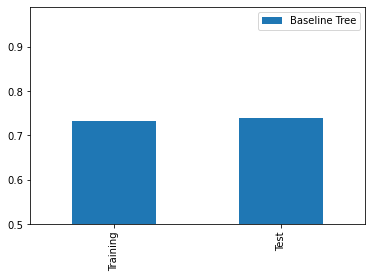

In [29]:
import xgboost as xgb
Xg_boost = xgb.XGBClassifier(n_jobs=-1, scale_pos_weight=1, objective = 'multi:softmax',colsample_bytree=0.5,learning_rate=0.1,max_depth=10,n_estimators=200,seed=0)
cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,Xg_boost,verbose=True)
plot_compare(Classification_results,'Baseline Tree',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['Baseline Tree', cv_scores, test_scores]

In [30]:
Xg_boost.fit(X,y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=0, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [31]:
prediction = Xg_boost.predict(TF)

In [32]:
submission = pd.DataFrame()
submission['building_id'] = test['building_id']
submission['damage_grade'] = prediction

In [33]:
submission.head(4)

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1


In [34]:
submission.to_csv('sub4.csv',index=False)

<Figure size 720x1440 with 0 Axes>

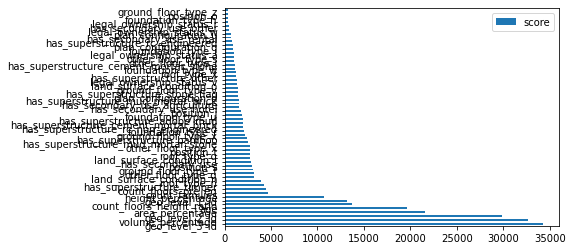

In [35]:
feature_important = Xg_boost.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

plt.figure(figsize=(10,20))
data.plot(kind='barh')

In [36]:
data

,score
geo_level_3_id,34318
volume_percentage,32667
geo_level_2_id,29879
area_percentage,21604
age,19657
count_floors_height_ratio,13676
geo_level_1_id,13177
height_percentage,10719
count_families,4630
count_floors_pre_eq,4459


In [37]:
data.tail(10)

,score
plan_configuration_q,889
has_superstructure_rc_engineered,851
has_secondary_use_rental,709
plan_configuration_u,638
legal_ownership_status_w,523
has_secondary_use_other,463
legal_ownership_status_r,422
foundation_type_h,420
position_o,384
ground_floor_type_z,343


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, geo_level_3_id to ground_floor_type_z
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   score   56 non-null     int64
dtypes: int64(1)
memory usage: 896.0+ bytes
